In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

In [254]:
df=pd.read_csv('heart.csv') 
df.head() 
df.info() 
df.describe() 
print("\n" + "="*50 + "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    int64  
 12  Thal       301 non-null    object 
 13  Target     303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB




In [255]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [256]:
numeric_cols = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']
print("### Outlier Cleaning (Capping) on All Numerical Columns ###")
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df[col] = np.clip(df[col], lower_limit, upper_limit)
    
    print(f"{col} cleaned. New Min: {df[col].min():.2f}, New Max: {df[col].max():.2f}")

### Outlier Cleaning (Capping) on All Numerical Columns ###
Age cleaned. New Min: 29.00, New Max: 77.00
RestBP cleaned. New Min: 94.00, New Max: 170.00
Chol cleaned. New Min: 126.00, New Max: 371.00
MaxHR cleaned. New Min: 86.00, New Max: 202.00
Oldpeak cleaned. New Min: 0.00, New Max: 4.00


In [257]:
categorical_cols = ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal', 'Target']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("\n" + "="*50 + "\n")
print(f"Remaining row count: {df.shape[0]}")
print("--- Final Status ---")
print(df.dtypes)



Remaining row count: 301
--- Final Status ---
Age             int64
Sex          category
ChestPain    category
RestBP          int64
Chol            int64
Fbs          category
RestECG      category
MaxHR           int64
ExAng        category
Oldpeak       float64
Slope        category
Ca           category
Thal         category
Target       category
dtype: object


C:\Users\amets\AppData\Local\Temp\ipykernel_14172\1644892933.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis', edgecolor='black')
C:\Users\amets\AppData\Local\Temp\ipykernel_14172\1644892933.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis', edgecolor='black')


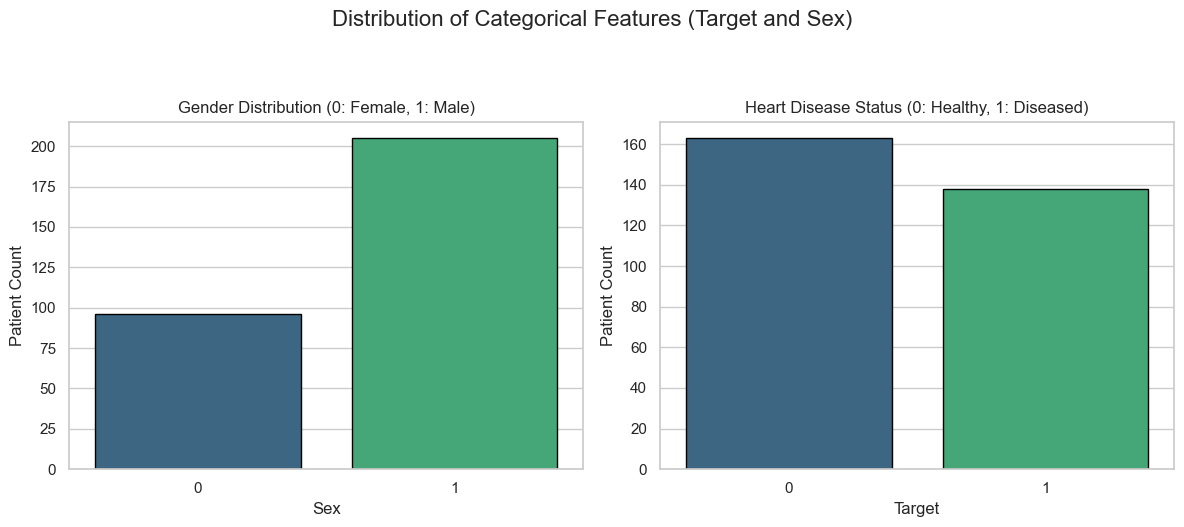

In [258]:
# Categorical Bar Charts
categorical_for_plot = ['Sex', 'Target'] 

plot_titles = {
    'Sex': 'Gender Distribution (0: Female, 1: Male)',
    'Target': 'Heart Disease Status (0: Healthy, 1: Diseased)'
}

plt.figure(figsize=(12, 5))
plt.suptitle('Distribution of Categorical Features (Target and Sex)', fontsize=16, y=1.05)

for i, col in enumerate(categorical_for_plot):
    plt.subplot(1, 2, i + 1)
    
    sns.countplot(x=col, data=df, palette='viridis', edgecolor='black')
    
    plt.title(plot_titles[col], fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Patient Count')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('categorical_bar_charts.png')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

numerical_cols = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']


In [259]:
# Numerical Histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() 

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=15, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

fig.delaxes(axes[5])
plt.suptitle('Univariate Analysis: Distribution of Key Numerical Features', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('numerical_histograms.png')
plt.close(fig)
print("numerical_histograms.png saved.")


numerical_histograms.png saved.


In [260]:
# Bivariate Analysis
print("--- 2. Generating Bivariate Analysis Plots ---")
# A)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Bivariate Analysis: Feature Relationships', fontsize=18)

sns.scatterplot(
    x='Age',
    y='Chol',
    hue='Target',
    data=df,
    ax=axes[0],
    palette='Set1',
    s=70, 
    alpha=0.7
)

axes[0].set_title('Age vs. Cholesterol (Colored by Heart Disease)', fontsize=14)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Cholesterol')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['No (0)', 'Yes (1)'], title='Heart Disease')

# B)
sns.boxplot(
    x='Sex',
    y='RestBP',
    data=df,
    ax=axes[1],
    palette='Set2'
)
axes[1].set_title('Resting Blood Pressure by Gender', fontsize=14)
axes[1].set_xlabel('Gender (0=Female, 1=Male)')
axes[1].set_ylabel('Resting Blood Pressure (RestBP)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('bivariate_analysis.png')
plt.close(fig)
print(" bivariate_analysis.png saved.")


--- 2. Generating Bivariate Analysis Plots ---


C:\Users\amets\AppData\Local\Temp\ipykernel_14172\2766962505.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


 bivariate_analysis.png saved.


In [261]:
# Correlation Analysis (Heatmap)
print("--- 3. Generating Correlation Heatmap ---")

corr_df = df.copy()
for col in corr_df.select_dtypes(include='category').columns:
    corr_df[col] = corr_df[col].cat.codes

correlation_matrix = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()
print("correlation_heatmap.png saved.")

--- 3. Generating Correlation Heatmap ---
correlation_heatmap.png saved.


In [262]:

print("\nEDA Visualization code execution complete.")


EDA Visualization code execution complete.


In [263]:
target_col = 'Target'
categorical_cols = ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

X = df.drop(target_col, axis=1)
y = df[target_col].astype(int)

In [264]:
print("\nOne-Hot Encoding")
X_ohe = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


One-Hot Encoding


In [265]:
print("\nLabel Encoding")
X_le = X.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_le[col] = le.fit_transform(X_le[col])
    label_encoders[col] = le


Label Encoding


In [266]:
def prepare_data(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
   
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train_A, X_test_A, y_train_A, y_test_A = prepare_data(X_ohe, y)
X_train_B, X_test_B, y_train_B, y_test_B = prepare_data(X_le, y)

In [267]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [268]:
def evaluate_models(strategy_name, X_tr, X_te, y_tr, y_te):
    print(f"\n=== Results: {strategy_name} ===")
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        y_prob = model.predict_proba(X_te)[:, 1]
        
        acc = accuracy_score(y_te, y_pred)
        roc = roc_auc_score(y_te, y_prob)
        report = classification_report(y_te, y_pred, output_dict=True)
        recall = report['1']['recall']

        cm = confusion_matrix(y_te, y_pred)
        print(f"Confusion Matrix:\n{confusion_matrix(y_te, y_pred)}\n")
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title("Confusion Matrix (Tuned Model)")
        plt.xlabel('Predicted Value')
        plt.ylabel('Actual Value')
        plt.show()
        print("-" * 40)

        
        print(f"Model: {name:20} | Accuracy: {acc:.2f} | Recall (Ilness): {recall:.2f} | ROC-AUC: {roc:.2f}")


=== Results: One-Hot Encoding ===
Confusion Matrix:
[[26  8]
 [ 7 20]]



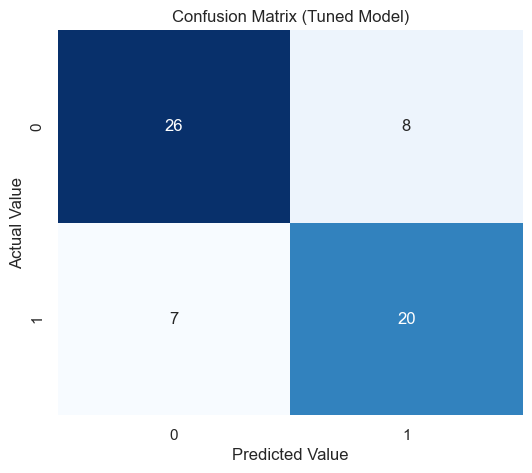

----------------------------------------
Model: Logistic Regression  | Accuracy: 0.75 | Recall (Ilness): 0.74 | ROC-AUC: 0.85
Confusion Matrix:
[[26  8]
 [10 17]]



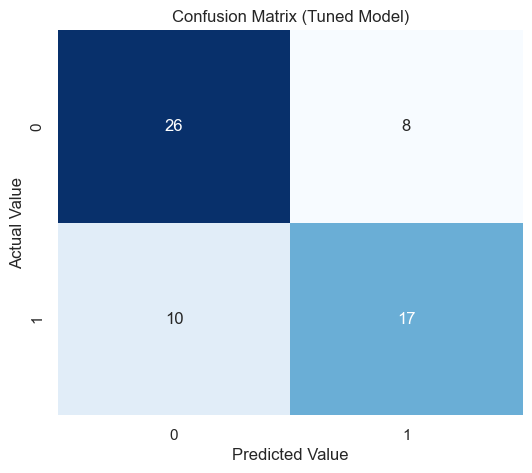

----------------------------------------
Model: Decision Tree        | Accuracy: 0.70 | Recall (Ilness): 0.63 | ROC-AUC: 0.70
Confusion Matrix:
[[31  3]
 [ 7 20]]



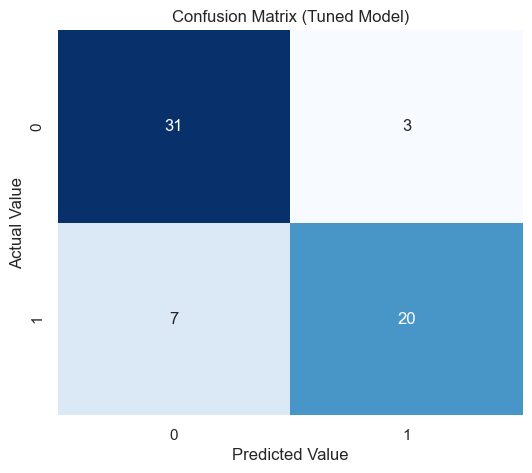

----------------------------------------
Model: SVM                  | Accuracy: 0.84 | Recall (Ilness): 0.74 | ROC-AUC: 0.85
Confusion Matrix:
[[28  6]
 [ 5 22]]



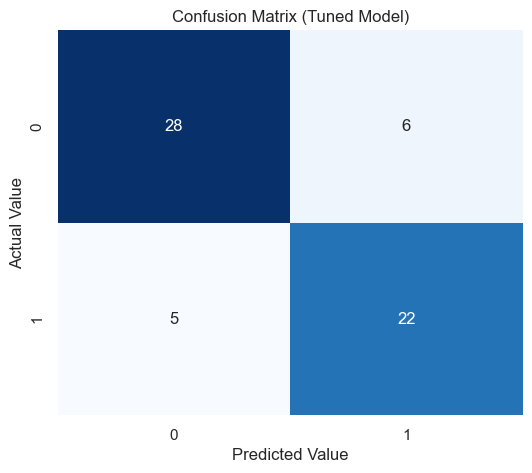

----------------------------------------
Model: Random Forest        | Accuracy: 0.82 | Recall (Ilness): 0.81 | ROC-AUC: 0.87

=== Results: Label Encoding ===
Confusion Matrix:
[[29  5]
 [ 8 19]]



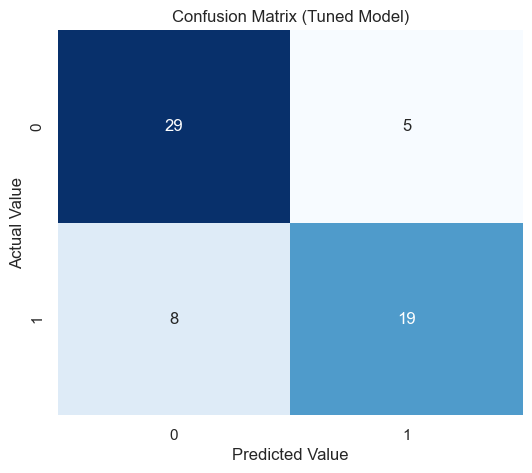

----------------------------------------
Model: Logistic Regression  | Accuracy: 0.79 | Recall (Ilness): 0.70 | ROC-AUC: 0.87
Confusion Matrix:
[[26  8]
 [10 17]]



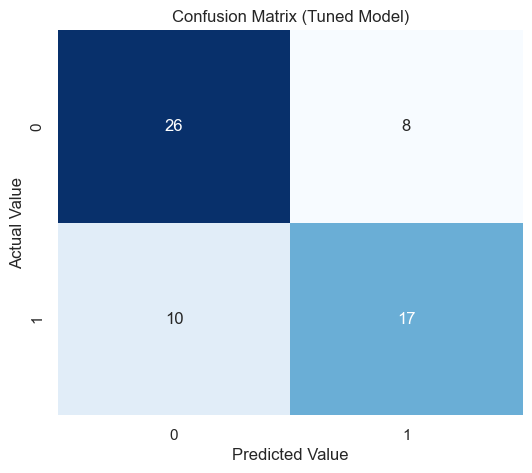

----------------------------------------
Model: Decision Tree        | Accuracy: 0.70 | Recall (Ilness): 0.63 | ROC-AUC: 0.70
Confusion Matrix:
[[29  5]
 [ 8 19]]



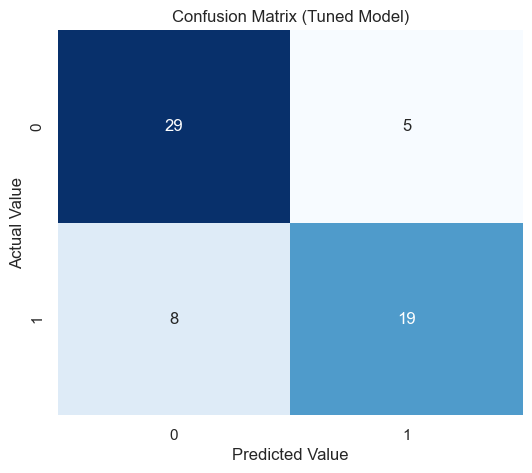

----------------------------------------
Model: SVM                  | Accuracy: 0.79 | Recall (Ilness): 0.70 | ROC-AUC: 0.87
Confusion Matrix:
[[28  6]
 [ 7 20]]



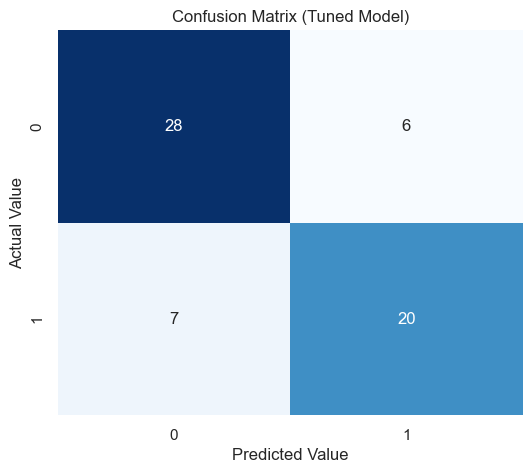

----------------------------------------
Model: Random Forest        | Accuracy: 0.79 | Recall (Ilness): 0.74 | ROC-AUC: 0.87


In [269]:
evaluate_models("One-Hot Encoding", X_train_A, X_test_A, y_train_A, y_test_A)
evaluate_models("Label Encoding", X_train_B, X_test_B, y_train_B, y_test_B)

In [270]:
print("\n=== Hyperparameter Tuning (Random Forest) ===")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


=== Hyperparameter Tuning (Random Forest) ===


In [271]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_A, y_train_A)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score (CV): {grid_search.best_score_:.2f}")

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best Recall Score (CV): 0.78


In [272]:
y_final_pred = best_model.predict(X_test_A)
print("\nFinal Tuned Model Rapor:")
print(classification_report(y_test_A, y_final_pred))


Final Tuned Model Rapor:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        34
           1       0.77      0.74      0.75        27

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



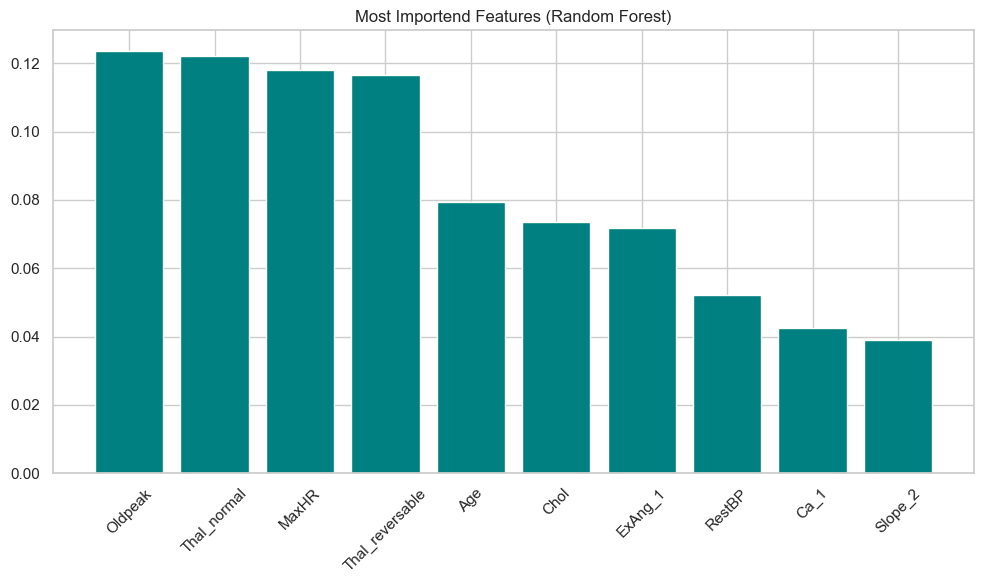

In [273]:
plt.figure(figsize=(10, 6))
importances = best_model.feature_importances_
feature_names = X_ohe.columns
indices = np.argsort(importances)[::-1][:10]

plt.title("Most Importend Features (Random Forest)")
plt.bar(range(10), importances[indices], align="center", color='teal')
plt.xticks(range(10), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()

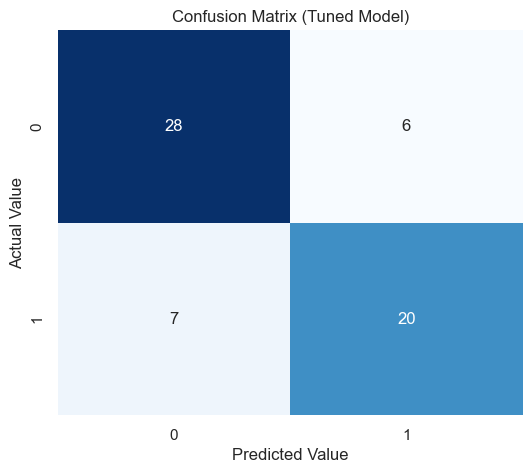

In [274]:
cm = confusion_matrix(y_test_A, y_final_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.show()

Key Insights from Exploratory Data Analysis (EDA)
1-Gender Prevalence: Heart diseases are more prevalent in male patients within the dataset.

2-Age Peak: The incidence of heart disease symptoms peaks around the age of 60 for both genders.

3-Cholesterol-Symptom Correlation: There is a positive correlation between high cholesterol levels and heart disease symptoms.

4-Critical Age Range: The positive relationship between high cholesterol and heart disease is dominant within the 50 to 60 age range.

5-Cholesterol Peak in Patients: The cholesterol level peak observed in heart disease patients is around 250 mg/dL, strongly supporting a definitive link between high cholesterol and the disease.

Hypothesis Refinement (Cholesterol as a Predictive Feature)

Based on the finding that the cholesterol peak in patients is 250 mg/dL, and referencing the clinical guideline that the maximum healthy total cholesterol limit is often considered 200 mg/dL, cholesterol is established as a definite and absolute predictive value for heart disease risk in this model.